<a href="https://colab.research.google.com/github/Vicente836/Practica-Ihealth/blob/S7/segm_to_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq
import pyvista
pyvista.set_jupyter_backend('static')
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../1-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../2-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../3-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../4-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselec

In [2]:
!pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 5.3 MB/s eta 0:00:00


In [3]:
import nibabel as nib
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import meshio

In [223]:
# takes a plane with voxel coordinates and returns only the edges corresponding to each segment and alle edges
def extract_edges(plane, axis):
  if axis=='4CH':
    RV = plane.threshold((1,1.1)).extract_feature_edges()
    EPI_extra = plane.threshold((2,2.1)).extract_feature_edges()
    LV = plane.threshold((3,3.1)).extract_feature_edges()
    EPI = pv.PolyData([])
    if len(EPI_extra.points)>0:
      EPI = EPI_extra.threshold((0,0.1))

  if axis=='ELVI':
    RV = pv.PolyData([])
    LV = plane.threshold((2,2.1)).extract_feature_edges()
    EPI_extra = plane.threshold((1,1.1)).extract_feature_edges()
    EPI = pv.PolyData([])
    if len(EPI_extra.points)>0:
      EPI = EPI_extra.threshold((0,0.1))

  if axis=='EC':
    RV = plane.threshold((1,1.1)).extract_feature_edges()
    LV = plane.threshold((3,3.1)).extract_feature_edges()
    EPI_extra  = plane.threshold((2,2.1)).extract_feature_edges()
    EPI=pv.PolyData([])
    if len(EPI_extra.points)>0:
      EPI = EPI_extra.threshold((0,0.1))

  return [LV, RV, EPI]

# takes the data of a nifti image and transform certatin slice i into real world coordinates
def slice_real_coordinates(image_data, num_slice, affine):
  shape = image_data.shape
  voxel_data = image_data[:,:,num_slice]
  # Create a grid of voxel coordinates
  x = np.arange(shape[0])
  y = np.arange(shape[1])
  z = np.array([num_slice])
  xx, yy, zz = np.meshgrid(x, y, z, indexing="ij")

  # Flatten the grid and create homogeneous coordinates
  voxel_coords = np.vstack((xx.flatten(), yy.flatten(), zz.flatten(), np.ones(xx.size)))

  # Apply the affine transformation to voxel coordinates
  real_world_coords = affine @ voxel_coords

  # Reshape the real-world coordinates back to match the voxel grid
  x_coords = real_world_coords[0, :].reshape((shape[0], shape[1], 1))
  y_coords = real_world_coords[1, :].reshape((shape[0], shape[1], 1))
  z_coords = real_world_coords[2, :].reshape((shape[0], shape[1], 1))

  # Create a structured grid in PyVista
  grid = pv.StructuredGrid(x_coords, y_coords, z_coords)
  grid["values"] = voxel_data.flatten(order='F')

  return grid

def nifti_to_mesh(nifti_file, axis='4CH'):
  nifti_data = nib.load(nifti_file)
  # Extract the image data as a NumPy array
  image_data = nifti_data.get_fdata()
  # Affine matrix to get real world coordinates
  affine = nifti_data.affine
  # Resolution of the image
  shape = image_data.shape
  # Number of slices in the nifti file
  num_slices = image_data.shape[2]
  LV_edges = []
  RV_edges = []
  EPI_edges = []
  slices = []

  # select a slice from the nifti file
  for i in range(num_slices):
    edges=[]
    sl = slice_real_coordinates(image_data, i, affine)
    LV, RV, EPI = extract_edges(sl, axis)
    if len(LV.points)>0:
      LV_edges.append(LV)
      edges.append(LV)
    if len(RV.points)>0:
      RV_edges.append(RV)
      edges.append(RV)
    if len(EPI.points)>0:
      EPI_edges.append(EPI)
      edges.append(EPI)
    if len(edges)>0:
      slices.append(pv.merge(edges))

  LV_final = []
  RV_final = []
  EPI_final = []
  if LV_edges:
    LV_final = pv.merge(LV_edges)
  if RV_edges:
    RV_final = pv.merge(RV_edges)
  if EPI_edges:
    EPI_final = pv.merge(EPI_edges)
  data_segm = [LV_final, RV_final, EPI_final]
  return data_segm, slices

In [224]:
data_segm_4CH, slices_4CH = nifti_to_mesh('0771_4CH_ED_segm.nii', axis='4CH')
LV_4CH, RV_4CH, EPI_4CH = data_segm_4CH
data_segm_EC, slices_EC = nifti_to_mesh('0771_EC_ED_segm.nii', axis='EC')
LV_EC, RV_EC, EPI_EC = data_segm_EC
data_segm_ELVI, slices_ELVI = nifti_to_mesh('0771_ELVI_ED_segm.nii', axis='ELVI')
LV_ELVI, RV_ELVI, EPI_ELVI = data_segm_ELVI

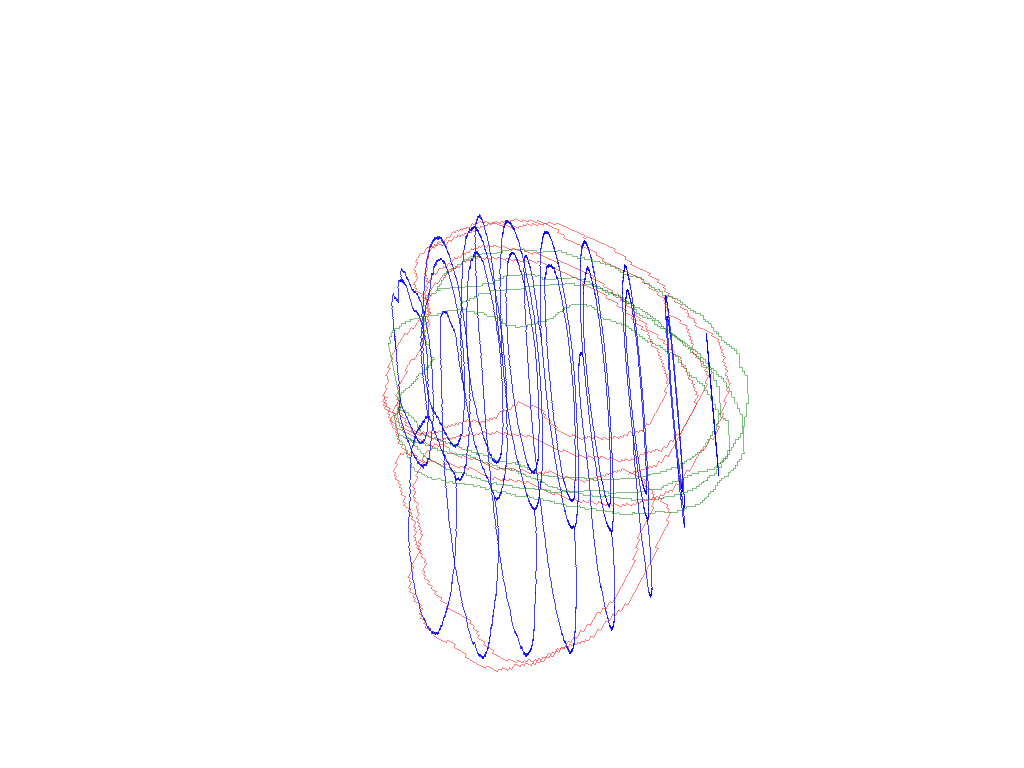

In [229]:
model1 = pv.merge(slices_EC)
model2 = pv.merge(slices_ELVI)
model3 = pv.merge(slices_4CH)
p = pv.Plotter()
p.add_mesh(LV_EC, color = 'blue', opacity=0.5)
p.add_mesh(RV_EC, color = 'blue', opacity = 0.5)
p.add_mesh(EPI_EC, color = 'blue', opacity=0.5)
p.add_mesh(LV_4CH, color = 'red', opacity=0.5)
p.add_mesh(RV_4CH, color = 'red', opacity = 0.5)
p.add_mesh(EPI_4CH, color = 'red', opacity=0.5)
p.add_mesh(LV_ELVI, color = 'green', opacity=0.5)
p.add_mesh(EPI_ELVI, color = 'green', opacity=0.5)
p.show()

pv.save_meshio('EC.vtk', model1)
pv.save_meshio('ELVI.vtk', model2)
pv.save_meshio('4CH.vtk', model3)